# Evaluation of GRN inference methods
## Processing results
### by Jalil Nourisa



# Imports

In [23]:
# Reload and autoreload settings for modules
%reload_ext autoreload
%autoreload 2

# Import necessary libraries
import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import sys
import numpy as np
import json
from scipy.stats import pearsonr
from pandas.api.types import CategoricalDtype
import seaborn
import matplotlib
from matplotlib.gridspec import GridSpec
import warnings
from grn_benchmark.src.helper import load_env
env = load_env()
# Suppress warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set plot parameters
plt.rcParams['font.family'] = 'Liberation Sans'  # Arial or 'Liberation Sans'
default_font = matplotlib.rcParams['font.family']
print(default_font)

# Add the src folder to the path
sys.path.insert(0, '../')
from src.helper import surrogate_names, colors_blind, palette_celltype, palette_methods, \
        DATASETS, plot_heatmap, ORDERED_METRICS, \
        read_yaml

TASK_GRN_INFERENCE_DIR = env['TASK_GRN_INFERENCE_DIR']
sys.path.insert(0, TASK_GRN_INFERENCE_DIR)
from src.utils.config import METHODS

# Set paths for task grn inference
results_folder = f'{TASK_GRN_INFERENCE_DIR}/resources/results'
scores_dir = f'{results_folder}/'
models = ['celloracle', 'grnboost', 'pearson_corr', 'positive_control', 'negative_control',
            'scenicplus','granie','figr','scglue','scenic','ppcor', 'portia', 'spearman_corr', 'scgpt', 'geneformer']

%matplotlib inline

['Liberation Sans']


In [24]:
def plot_raw_scores(df_all, dataset, ax):
    scores_mat = df_all[df_all['dataset'] == dataset]
    scores_mat = scores_mat.set_index('model').drop(columns='dataset')
    scores_mat = scores_mat.dropna(how='all', axis=1)
    
    scores_mat = scores_mat[[c for c in ORDERED_METRICS if c in scores_mat.columns]]
    scores_mat.columns = scores_mat.columns.map(lambda name: surrogate_names.get(name, name))
    scores_mat.index = scores_mat.index.map(lambda name: surrogate_names.get(name, name))
    scores_mat = scores_mat.astype(float)
    ranks = scores_mat.rank(axis=0, ascending=False, method='min')
    scores_mat['_overall_rank'] = ranks.mean(axis=1, skipna=True)
    scores_mat = scores_mat.sort_values(by='_overall_rank').drop(columns=['_overall_rank'])
    plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
    ax.set_ylabel('')
    return scores_mat.index
def process_trace_func(trace):
    cols = ['%cpu', 'peak_rss', 'peak_vmem', 'rchar', 'wchar']
    datasets = DATASETS
    t_store = []
    for model in METHODS:
        for i, row in trace.iterrows():
            if f'{model}_process' in row['name']:
                t = trace.loc[[i], cols]
                t['model'] = model

                for dataset in datasets:
                    if dataset in row['name']:
                        t['dataset'] = dataset
                        t_store.append(t)
                        break

    trace_df = pd.concat(t_store).reset_index()
    if True:
        # Conversion factors
        unit_to_bytes = {
            "KB": 1024,
            "MB": 1024**2,
            "GB": 1024**3,
            "B": 1
        }

        def convert_to_gb(value):
            if pd.isna(value):
                return None
            value = str(value).strip()
            try:
                num, unit = value.split()
                num = float(num)
                unit = unit.upper()
                if unit in unit_to_bytes:
                    return num * unit_to_bytes[unit] / (1024**3)  # convert bytes → GB
                else:
                    return float(num)  # fallback if no unit
            except Exception:
                return None

        # - remove GB and MB from the columns
        # Apply conversion
        for col in ["peak_rss", "peak_vmem", "rchar", "wchar"]:
            trace_df[col] = trace_df[col].apply(convert_to_gb)

        # Rename columns with consistent units
        for col in ["%cpu"]:
            trace_df[col] = trace_df[col].str.replace(r"[^0-9.]", "", regex=True).astype(float)

        trace_df.rename(
            columns={
                "%cpu": "CPU Usage (%)",
                "peak_rss": "Peak RSS (GB)",
                "peak_vmem": "Peak VMem (GB)",
                "rchar": "Read Chars (GB)",
                "wchar": "Written Chars (GB)"
            },
            inplace=True
        )
        trace_df = trace_df.round(2)
    
    return trace_df

# GRN inference and evaluation

GRN inference and evaluation are two seperate pipelines. Download and install https://github.com/openproblems-bio/task_grn_inference, then:
Inside `scripts/run_all.sh`, select the relevant step. GRN inference is very computational intensive.

# Download results
Once the results are obtained, run the following cells to download the results for this notebook.

In [13]:
if True:
    # for dataset in DATASETS:
    for dataset in ['op', 'replogle']:
        !aws s3 sync s3://openproblems-data/resources/grn/results/{dataset} {results_folder}/{dataset} --no-sign-request

download: s3://openproblems-data/resources/grn/results/op/score_uns.yaml to ../../task_grn_inference/resources/results/op/score_uns.yaml
download: s3://openproblems-data/resources/grn/results/op/trace.txt to ../../task_grn_inference/resources/results/op/trace.txt
download: s3://openproblems-data/resources/grn/results/replogle/state.yaml to ../../task_grn_inference/resources/results/replogle/state.yaml
download: s3://openproblems-data/resources/grn/results/replogle/trace.txt to ../../task_grn_inference/resources/results/replogle/trace.txt
download: s3://openproblems-data/resources/grn/results/replogle/score_uns.yaml to ../../task_grn_inference/resources/results/replogle/score_uns.yaml
download: s3://openproblems-data/resources/grn/results/replogle/metric_configs.yaml to ../../task_grn_inference/resources/results/replogle/metric_configs.yaml


# Scores datasets

In [14]:
!python {TASK_GRN_INFERENCE_DIR}/src/process_data/process_trace_files.py

Base directory: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/
Datasets to process: op, parsebioscience, 300BCG, ibd, replogle, xaira_HEK293T, xaira_HCT116, nakatake, norman, adamson


Processing dataset: op
Input directory: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/op
Output file: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/op/trace_merged.txt
Found 3 trace file(s)
  Processing: trace.txt
    → Found 122 completed task(s)
  Processing: trace_2025-11-16.txt
    → Found 83 completed task(s)
  Processing: trace_merged.txt
    → Found 181 completed task(s)

Total completed tasks found: 386
Unique methods found: 98
Tasks from most recent runs: 211
✓ Merged file written: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/op/trace_merged.txt

Dataset: parsebioscience
⚠ Directory not found: /home/jnourisa/projs/ongoing/task_grn_inference/resources/results/parsebioscience
Skipping...

Dataset: 300BCG
⚠ Directory n

In [25]:
process_trace = True
from src.helper import read_yaml
if True:
    scores_store = []
    trace_df_store = []
    for dataset in ['op', 'replogle']: 
        scores_file = f"{TASK_GRN_INFERENCE_DIR}/resources/results/{dataset}/score_uns.yaml"
        if os.path.exists(scores_file):
            df = read_yaml(scores_file)
            df.fillna(0, inplace=True)
            scores_store.append(df)
        if process_trace:
            trace = pd.read_csv(f"{TASK_GRN_INFERENCE_DIR}/resources/results/{dataset}/trace_merged.txt", sep='\t')
            trace = process_trace_func(trace)
            trace_df_store.append(trace)
    scores_all = pd.concat(scores_store)
    scores_all.columns.name = ''
    if process_trace:
        trace_all = pd.concat(trace_df_store)
        if 'task_id' in trace_all.columns:
            trace_all = trace_all.drop(columns=['task_id'])
        trace_all.index.name = ''
        trace_all.drop('index', axis=1, inplace=True)
        # assert scores_all['model'].unique().tolist() == trace_all['model'].unique().tolist(), "Trace data does not match expected models"
else:
    scores_file = f"{TASK_GRN_INFERENCE_DIR}/resources/results/{dataset}/scores.yaml"
    scores_all = read_yaml(scores_file)
scores_all = scores_all[scores_all['model'].isin(METHODS)]

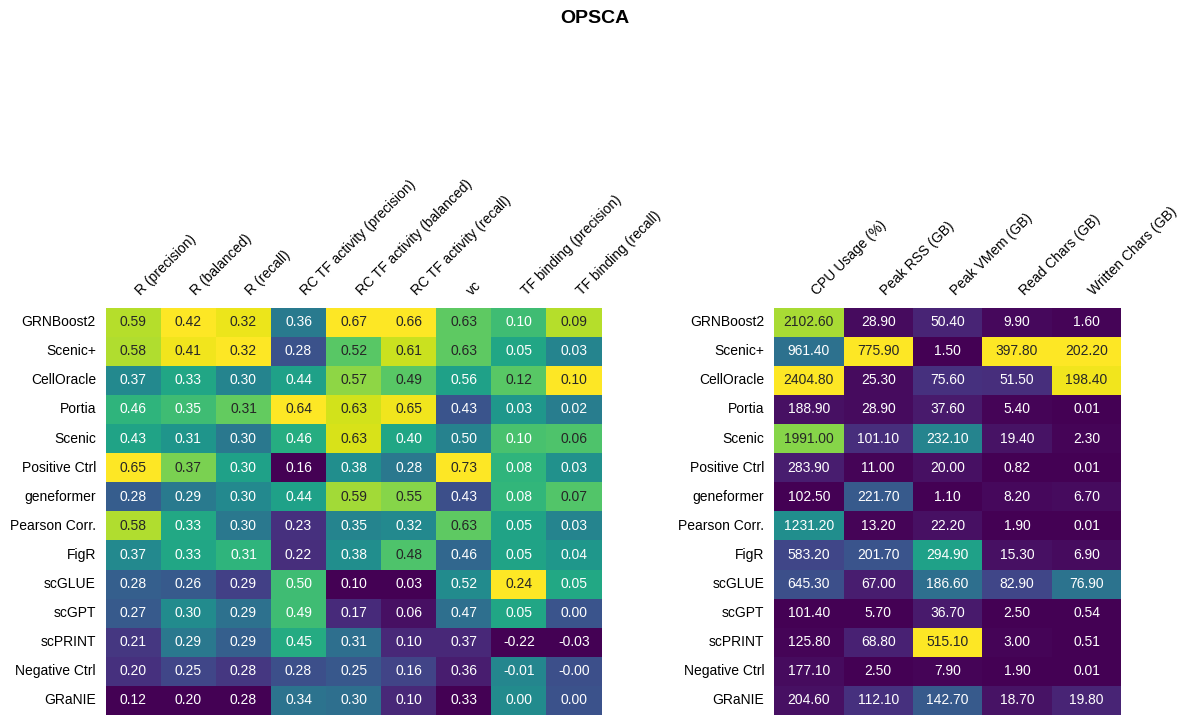

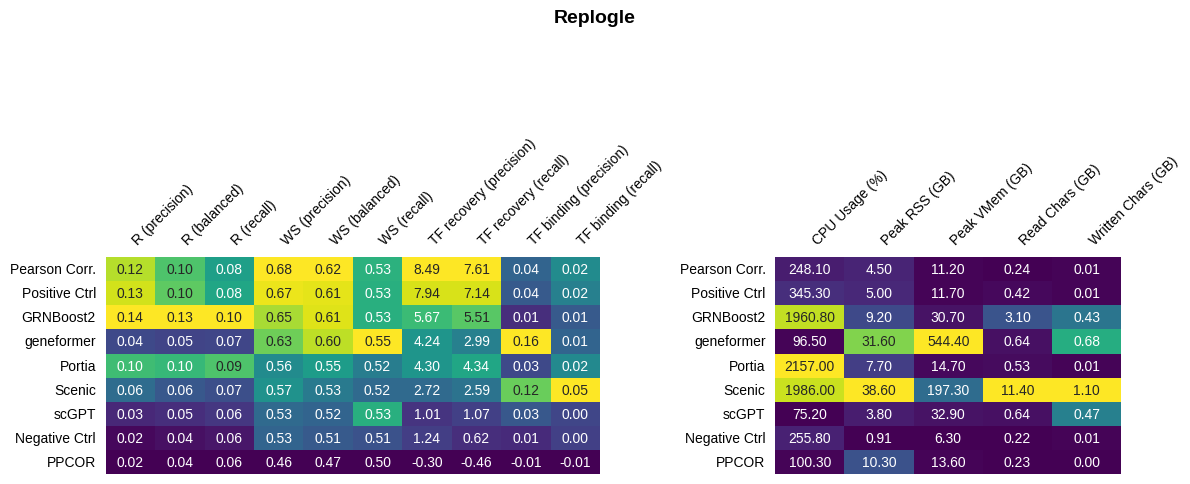

In [27]:
for dataset in ['op', 'replogle']: 
    if dataset in ['replogle', 'xaira_HCT116', 'xaira_HEK293T']:
        figsize=(12, 4)
    elif dataset in ['op', 'ibd']:
        figsize=(12, 6)
    elif dataset in ['300BCG', 'parsebioscience']:
        figsize=(5, 4)
    elif dataset in ['norman', 'adamson']:
        figsize=(4, 4)
    else:
        figsize=(3, 4)
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False, width_ratios=[1, 0.7])
    try:
        ax = axes[0]
        ordered_methods = plot_raw_scores(scores_all, dataset, ax)
        ax = axes[1]
        df = trace_all[trace_all['dataset'] == dataset]
        scores_mat = df.set_index('model').drop(columns='dataset')
        scores_mat.index = scores_mat.index.map(lambda name: surrogate_names.get(name, name))
        scores_mat = scores_mat.dropna(how='all', axis=1)
        scores_mat = scores_mat.loc[[c for c in ordered_methods if c in scores_mat.index]]
        plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
        ax.set_ylabel('')
    except Exception as e:
        print(f"Error plotting for {dataset}: {e}")
        continue

    plt.suptitle(surrogate_names.get(dataset, dataset), y=1.2, fontsize=14, weight='bold')
    plt.tight_layout()
    # fig.savefig(f"{results_folder}/figs/raw_scores_{dataset}.png", dpi=300, transparent=True, bbox_inches='tight')
    # fig.savefig(f"{TASK_GRN_INFERENCE_DIR}/docs/source/images/raw_scores_{dataset}.png", dpi=300, transparent=True, bbox_inches='tight')

# Overview of performance

In [ ]:
df_res = pd.read_csv(f'{TASK_GRN_INFERENCE_DIR}/resources/results/trace.csv', index_col=0)

In [ ]:
# - read the scores
metrics = [m for m in scores_all.columns.tolist() if m in ORDERED_METRICS]
# - normalize the scores
def normalize_scores_per_dataset(df):
    df = df.set_index('model')
    df[df < 0] = 0
    df = (df-df.min(axis=0))/(df.max(axis=0)-df.min(axis=0))
    return df
df_all_n = scores_all.groupby('dataset').apply(normalize_scores_per_dataset).reset_index()

# - average scores for all datasets 
def mean_for_metrics(df):
    # Calculate mean across datasets for each metric, ignoring NaN values
    return df.drop(['dataset'], axis=1).mean(skipna=True)

df_metrics = (
    df_all_n.groupby(['model'])
    .apply(mean_for_metrics)
)

# - average scores for all datasets 
def mean_for_datasets(df):
    # print(df.set_index('dataset')[metrics].T.mean(skipna=True))
    return df.set_index('dataset')[metrics].T.mean(skipna=True)

df_datasets = (
    df_all_n.groupby(['model'])
    .apply(mean_for_datasets)
    .reset_index()
)
df_datasets = df_datasets.pivot(index='model',columns='dataset',values=0)

# - calculate over scores
df_scores = pd.concat([df_metrics, df_datasets], axis=1)
# df_scores = df_metrics
df_scores['overall_score'] = df_scores.mean(axis=1, skipna=True)

# - merge scores with resources 
df_summary = pd.concat([df_scores, df_res], axis=1)
df_summary = df_summary.fillna(0)
df_summary.index.name = 'method_name' 
df_summary = df_summary.reset_index()

df_summary = df_summary.sort_values(by='overall_score', ascending=False) 
df_summary
df_summary.method_name = df_summary.method_name.map(surrogate_names)
# - add user complexity 
df_summary['User-friendly'] = df_summary['method_name'].map({
                            'Scenic+': 1, 
                            'GRNBoost2': 8, 
                            'Positive Ctrl': 10, 
                            'Pearson Corr.': 10,
                            'Spearman Corr.': 10,
                            'CellOracle': 6,
                            'Portia': 9,
                            'scGLUE': 6,
                            'Scenic': 7,
                            'FigR': 6,
                            'PPCOR': 7,
                            'Negative Ctrl': 10,
                            'GRaNIE': 6,
                            'scPRINT': 5,
                            'GeneFormer': 5,
                            'scGPT': 3,
                            })
df_summary['Complexity'] = df_summary['User-friendly'].max() - df_summary['User-friendly']
df_summary.columns = [surrogate_names.get(col, col) for col in df_summary.columns]

df_summary= df_summary.fillna(0)


summary_file = f"{results_folder}/summary.tsv"
summary_figure = f"{results_folder}/summary_figure"

df_summary['memory_log'] = np.log(df_summary['Peak memory (GB)']+1)
df_summary['memory_log'] = np.max(df_summary['memory_log'])-df_summary['memory_log']

df_summary['complexity_log'] = np.log(df_summary['Complexity']+1)
df_summary['complexity_log'] = np.max(df_summary['complexity_log'])-df_summary['complexity_log']

df_summary["duration_log"] = np.log(df_summary['Duration (hour)']+1)
df_summary['duration_log'] = np.max(df_summary['duration_log'])-df_summary['duration_log']

df_summary["duration_str"] = df_summary['Duration (hour)'].round(1).astype(str)
df_summary['memory_str'] =  df_summary['Peak memory (GB)'].round(1).astype(str)

df_summary.to_csv(summary_file, sep='\t')

!Rscript ../src/summary_figure.R {summary_file} {summary_figure}
